In [86]:
# ====== Packages =======
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# ---- user defined modules ----
import pre_proccessing_helpers as hel
import models_helpers as mh

%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10


In [140]:
class Net(nn.Module):
    def __init__(self, nuerons_num: list):
        super().__init__()
        self.fc1 = nn.Linear(nuerons_num[0], nuerons_num[1])
        self.fc2 = nn.Linear(nuerons_num[1], nuerons_num[2])
        self.fc3 = nn.Linear(nuerons_num[2], nuerons_num[3])
        self.fc4 = nn.Linear(nuerons_num[3], nuerons_num[4])
        
    
    def forward(self, net_input):
        z = self.fc1(net_input)
        a = F.relu(z)
        z = self.fc2(a)
        a = F.relu(z)
        z = self.fc3(a)
        a = F.relu(z)
        z = self.fc4(a)

        return torch.sigmoid(z)



In [187]:
dataset2 = pd.read_pickle('data_for_tree2.pkl')
X_train_raw, y_train_raw, X_test, y_test = mh.data_split(dataset2 ,n_splits=1, test_size=0.4, train_size=0.6)
X_train, y_train = mh.up_down_sampling(X_train_raw, y_train_raw, ratio=1, up=True)

data_test = pd.concat([X_test, y_test], axis=1)
X_test, y_test, X_val, y_val = mh.data_split(data_test , n_splits=1, test_size=0.5, train_size=0.5)


X_train, y_train, X_test, y_test, X_val, y_val = (torch.from_numpy(X_train.values), torch.from_numpy(y_train.values), 
                                                 torch.from_numpy(X_test.values), torch.from_numpy(y_test.values), 
                                                 torch.from_numpy(X_val.values), torch.from_numpy(y_val.values))


In [8]:
dataset2

,test_week,cough,fever,sore_throat,shortness_of_breath,head_ache,symp_num,test_indication_0,test_indication_1,test_indication_2,corona_result
0,18,0,0,0,0,0,0,1,0,0,0
1,18,1,0,0,0,0,1,1,0,0,0
2,18,0,1,0,0,0,1,1,0,0,0
3,18,1,0,0,0,0,1,1,0,0,0
4,18,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
274697,11,0,0,0,0,0,0,1,0,0,0
274698,11,0,0,0,0,0,0,1,0,0,0
274699,11,0,0,0,0,0,0,1,0,0,0
274700,11,0,0,0,0,0,0,0,1,0,1


In [147]:
X_train.size()

torch.Size([312010, 10])

### Split the data to batches:

#### Note: the smaller the batch size the noisier the learning proccess and vise versa. a balance between them should be found. according to Google's TabNet's documentation the batch size should be up to 10% of the size of the training set.

In [148]:
batch_size = 2**14
y_train = torch.reshape(y_train, (y_train.size()[0], 1))
train_set = torch.cat((X_train, y_train), dim=1)

# Shuffle the data before spliting so we wont get batches of all ones and all zeros
train_set = train_set[torch.randperm(train_set.size()[0]),:].float()
batches = torch.split(train_set, batch_size)


In [150]:
batches[2][:,-1]

tensor([0., 1., 1.,  ..., 0., 1., 0.])

## Train the model:

In [192]:
net = Net([10, 30, 60,30,1])
loss_func = nn.BCELoss()
#optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay = 0.)
epoches = 100
cost_train_list = []
cost_val_list = []
iter_list = []
j = 0
i = 0
 
for epoch in tqdm(range(epoches), desc='epoch'):
    j = i + j 
    for i, batch in enumerate(tqdm(batches, desc='batch')):
        # get inputs and targets
        inputs, targets = batch[:,:-1], batch[:, -1]
        targets = torch.reshape(targets, (inputs.size()[0], 1))
        y_val = torch.reshape(y_val, (X_val.size()[0], 1))
        # zero the parameters gradients 
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs)
        cost = loss_func(outputs, targets)
        cost.backward()
        optimizer.step()

        # get statistics
        if i % 40 == 0: # print every 10 mini-batches
            cost_val = loss_func(net.forward(X_val.float()), y_val.float())
            cost_val_list.append(cost_val.detach().numpy())
            cost_train_list.append(cost.detach().numpy())

            iter_list.append(j+i+1)
        

print('Finished Training')

epoch: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]

Finished Training


## Google's TabNet:

In [185]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# define the model
clf1_nopreproc = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )


# fit the model 
clf1_nopreproc.fit(
    X_train.values,y_train.values,
    eval_set=[(X_train.values, y_train.values), (X_val.values, y_val.values)],
    eval_name=['train', 'valid'],
    eval_metric=['auc','accuracy'],
    max_epochs=1000 , patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False)

Device used : cpu
epoch 0  | loss: 0.35184 | train_auc: 0.90906 | train_accuracy: 0.8646  | valid_auc: 0.90648 | valid_accuracy: 0.92945 |  0:01:44s
epoch 1  | loss: 0.34437 | train_auc: 0.90882 | train_accuracy: 0.86496 | valid_auc: 0.90713 | valid_accuracy: 0.93129 |  0:03:22s
epoch 2  | loss: 0.34357 | train_auc: 0.90921 | train_accuracy: 0.8624  | valid_auc: 0.90751 | valid_accuracy: 0.94283 |  0:05:06s
epoch 3  | loss: 0.34144 | train_auc: 0.90824 | train_accuracy: 0.86397 | valid_auc: 0.90612 | valid_accuracy: 0.9328  |  0:06:50s
epoch 4  | loss: 0.3408  | train_auc: 0.90952 | train_accuracy: 0.86546 | valid_auc: 0.90806 | valid_accuracy: 0.92889 |  0:08:48s
epoch 5  | loss: 0.34291 | train_auc: 0.90936 | train_accuracy: 0.86461 | valid_auc: 0.90703 | valid_accuracy: 0.92128 |  0:10:30s
epoch 6  | loss: 0.34333 | train_auc: 0.90908 | train_accuracy: 0.8643  | valid_auc: 0.90731 | valid_accuracy: 0.93371 |  0:12:17s
epoch 7  | loss: 0.3414  | train_auc: 0.90944 | train_accuracy: 0

KeyboardInterrupt: 

### Hyper parameters Tuning:

## Evaluation:

### Plot cost function:

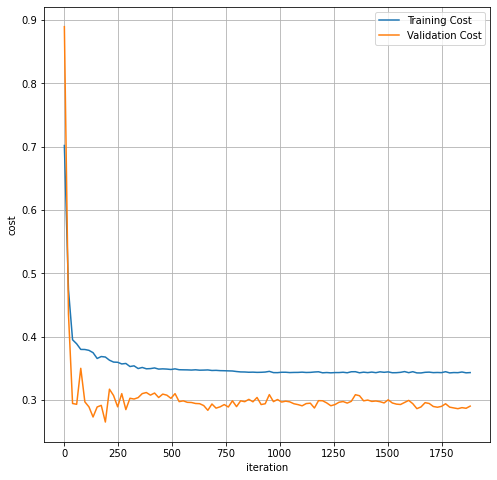

In [193]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(iter_list, cost_train_list, label = 'Training Cost')
ax.plot(iter_list, cost_val_list, label = 'Validation Cost')
ax.set_xlabel('iteration')
ax.set_ylabel('cost')
ax.legend()


### Check model performance on training set:

+--------------+--------------------+
|    Metric    |       Score        |
+--------------+--------------------+
|   accuracy   | 0.865677382135188  |
|    recall    | 0.7893336752027179 |
|  presicion   | 0.9315731739607368 |
|   f1 score   | 0.8545751067004407 |
| f_beta score | 0.8141972084289314 |
+--------------+--------------------+


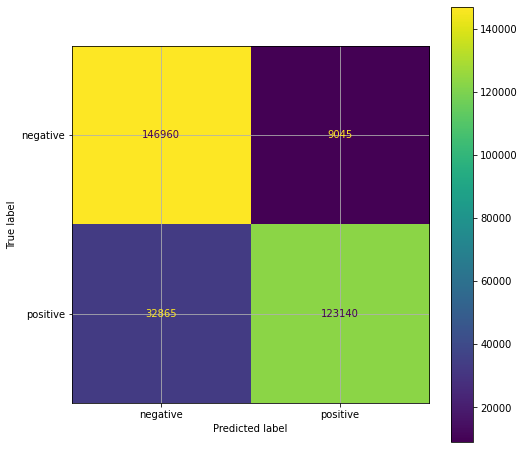

In [194]:
y_pred = 1*(net.forward(X_train.float())>0.5)
mh.model_evaluation(y_train.detach().numpy(), y_pred.detach().numpy())

### Check model performance on test set:

+--------------+--------------------+
|    Metric    |       Score        |
+--------------+--------------------+
|   accuracy   | 0.9337095012741172 |
|    recall    | 0.7733923103096291 |
|  presicion   | 0.4330348637835778 |
|   f1 score   | 0.5552027357107963 |
| f_beta score | 0.6683328432813878 |
+--------------+--------------------+


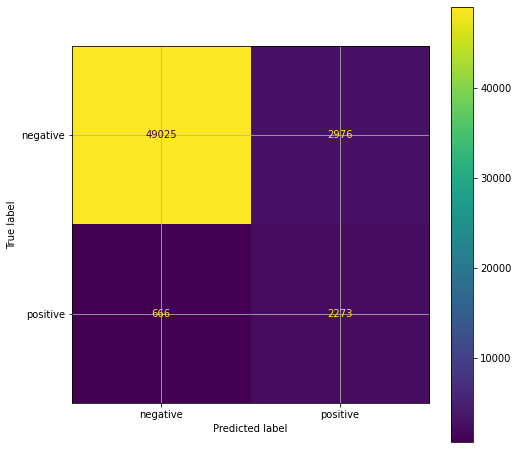

In [195]:
y_pred = 1*(net.forward(X_test.float())>0.5)
mh.model_evaluation(y_test.detach().numpy(), y_pred.detach().numpy())